In [1]:
#@title Env
from gym.utils import seeding
import gym
from gym import spaces
import numpy as np
from enum import Enum
import matplotlib.pyplot as plt
import pandas as pd
import math
pd.options.mode.chained_assignment = None


class Actions(Enum):
    # Mappo sono le azioni legittime nella forma:
    # StatoAzione
    DoNothing = 0
    OpenLongPos = 1
    OpenShortPos = 2

    # Potrei anche mappare solo le quattro azioni e poi dare il reward negativo sull'azione in base alla posizione corrente (che comunque devo tenermi salvata)


class Positions(Enum):
    # La posizione è lo stato attuale in cui si trova l'algoritmo.
    # In Free è permesso solo di fare DoNothing e OpenPosition
    # in Long è permesso di fare solo HoldPosition e ClosePosition
    Free = 0
    Long = 1
    Short = 2

    def switch_position(self, action):

        # Switch per la parte long
        if self == Positions.Free and action == Actions.OpenLongPos.value:
            return Positions.Long
        if self == Positions.Long and action == Actions.OpenShortPos.value:
            return Positions.Free

        # Switch per la parte short
        if self == Positions.Free and action == Actions.OpenShortPos.value:
            return Positions.Short
        if self == Positions.Short and action == Actions.OpenLongPos.value:
            return Positions.Free


class CryptoTradingEnv(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self, df, frame_bound, window_size: int = 22,
                 indicators=['diff_pct_1', 'diff_pct_5', 'diff_pct_15', 'diff_pct_22'],
                 position_in_observation: bool = True):
        assert df.ndim == 2
        assert len(frame_bound) == 2
        self.indicators_to_use = indicators
        self.seed()
        # TODO cambia nome
        self.df = df
        self.frame_bound = frame_bound
        self.window_size = window_size
        self.prices, self.signal_features = self._process_data()

        self.position_in_observation = position_in_observation

        if self.position_in_observation:
            self.shape = (window_size, self.signal_features.shape[1] + 1)
        else:
            self.shape = (window_size, self.signal_features.shape[1])

        self.invalid_action_replay = True
        self._invalid_action = False
        self._count_invalid_action = 0
        # spaces
        self.action_space = spaces.Discrete(len(Actions))
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=self.shape, dtype=np.float32)

        # episode
        self._balance = 10000.
        self._start_tick = self.window_size
        self._end_tick = len(self.prices) - 1
        self._done = None
        self._current_tick = None
        self._open_position_tick = None
        self._holding_price_difference = np.zeros(0)
        self._last_trade_tick = None
        self._position = Positions.Free
        self._position_history = None
        self._total_reward = 0.
        self._total_profit = 0.
        self._first_rendering = None
        self.history = None
        # TODO prevedi un flag per attivare questa funzione
        # self._max_profit_possible = self.max_possible_profit()
        self._max_profit_possible = 0
        self._profit_in_step = np.zeros(0)

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def reset(self):
        self._invalid_action = False
        self._balance = 10000.
        self._done = False
        self._current_tick = self._start_tick
        self._open_position_tick = 0
        self._last_trade_tick = self._current_tick - 1
        self._position = Positions.Free
        self._position_history = ([Positions.Free.value] * (self.window_size - 1)) + [self._position.value]
        self._total_reward = 0.
        self._total_profit = 0.  # unit
        self._first_rendering = True
        self.history = {}
        self._holding_price_difference = np.zeros(0)
        self._count_invalid_action = 0
        self._profit_in_step = [0] * self.window_size
        self.balance_array = [10000]

        self.returns_balance = dict()
        self.returns_balance[self._current_tick] = 10000

        return self._get_observation()

    # change in sharpe_ratio_reward
    def sharpe_calculator(self, current_balance, rf=0):
        key_list = list(self.returns_balance.keys())
        returns_list = list(self.returns_balance.values())[key_list.index(self._open_position_tick):]
        roi = (returns_list[-1] - returns_list[0]) / returns_list[0] * 100
        std = np.array(returns_list).std()
        sharpe_ratio = (roi - rf) / std
        if math.isnan(sharpe_ratio):
            sharpe_ratio = 0
        return sharpe_ratio

    def sharpe_calculator_total(self, rf=0):

        returns_list = list(self.returns_balance.values())
        roi = (returns_list[-1] - returns_list[0]) / returns_list[0] * 100
        std = np.array(returns_list).std()
        sharpe_ratio = (roi - rf) / std
        return sharpe_ratio

    def sharpe_calculator_total_quantstats(self):
        returns_list = list(self.returns_balance.values())
        pd_returns_list = pd.DataFrame(returns_list)
        sharpe = qs.stats.sharpe(pd_returns_list, rf=0., periods=252, annualize=False, trading_year_days=252)
        return sharpe

    def sharpe_calculator_quantstats(self):
        key_list = list(self.returns_balance.keys())
        returns_list = list(self.returns_balance.values())[key_list.index(self._open_position_tick):]
        pd_returns_list = pd.DataFrame(returns_list)
        sharpe = qs.stats.sharpe(pd_returns_list, rf=0., periods=252, annualize=False, trading_year_days=252)
        return sharpe

    def sortino_calculator_quantstats(self):
        key_list = list(self.returns_balance.keys())
        returns_list = list(self.returns_balance.values())[key_list.index(self._open_position_tick):]
        pd_returns_list = pd.DataFrame(returns_list)
        sortino = qs.stats.sortino(pd_returns_list, rf=0., periods=252, annualize=False, trading_year_days=252)
        return sortino

    def sortino_calculator_total_quantstats(self):
        returns_list = list(self.returns_balance.values())
        pd_returns_list = pd.DataFrame(returns_list)
        sortino = qs.stats.sortino(pd_returns_list, rf=0., periods=252, annualize=False, trading_year_days=252)
        return sortino

    def step(self, action):
        '''
        Responsabilità di step():
            1. calcolare il profit attraverso la funzione di update_profit
            2. calcolare step_reward, position, open_position_tick tramite la funzione calculate_reward()
            4. aggiornare la history delle posizioni
        '''
        self._invalid_action = False
        self._done = False

        self._update_profit(action)
        # Attenzione! self._position viene cambiata in step_reward quindi update_profit() deve essere chiamato prima
        step_reward = self._calculate_reward(action)

        info = dict(
            total_reward=self._total_reward,
            total_profit=self._total_profit,
            balance=self._balance,
            position=self._position.value
        )

        if not self._invalid_action:
            self._current_tick += 1
            self._position_history.append(self._position.value)
            self._profit_in_step = np.append(self._profit_in_step, self._total_profit)

        if self._current_tick == self._end_tick:
            self._done = True

        observation = self._get_observation()

        return observation, step_reward, self._done, info

    def _calculate_reward(self, action):
        '''
        Responsabilità di calculate_reward:
            1. Calcolare il reward
            2. Aggiornare self._total_reward
            3. Aggiornare self._position
            4. Aggiornare self._open_position_tick

        Logica di reward per azioni LEGITTIME:
                    - ClosePosition (da Long a Free) = profit di quella posizione
                    - OpenPosition (da Free a Long) = reward di incentivo per aprire posizione
                    - HoldPosition (da Long a Long) = profit che verrebbe fatta da quando si è aperta la posizione se si vendesse in quel momento
                    - DoNothing (da Free a Free) = 0 di reward, non punisco e lo incentivo in nessun modo su questa posizione

        Logica di reward per azioni ILLEGITTIME (tutte le coppie non listate sopra):
                    - Do un piccolo reward negativo di disincentivo per tutte le azioni illeggitime
                        ma non faccio cambiare il sistema

        Funzione di transizione: (Stato, Azione) -> Stato

        :param action:
        :return:
        '''

        # è negativo quando fa un'azione invalida?
        step_reward = 0
        new_position = self._position

        # (Free, DoNothing) -> Free
        if action == Actions.DoNothing.value and self._position == Positions.Free:
            step_reward = 0
            # reinserisce l'ultima posizione
            # self.returns_balance = {self._current_tick : 10000}
            last_key = list(self.returns_balance.keys())[-1]
            self.returns_balance[self._current_tick] = self.returns_balance[last_key]
            # self.balance_array.append(self.balance_array[-1])


        # (Free, OpenPosition) -> Long
        elif action == Actions.OpenLongPos.value and self._position == Positions.Free:
            new_position = self._position.switch_position(action)
            self._open_position_tick = self._current_tick
            # 1 è troppo alto? Ma se metto a 0.95 fa un trade ogni ora
            # così ne fa uno ogni due tre minuti

            step_reward = 0
            last_key = list(self.returns_balance.keys())[-1]
            self.returns_balance[self._current_tick] = self.returns_balance[last_key]

        # 0 aperta posizione a 10
        # holding_rewards = []
        # 1 prezzo a 12 -> hold 12-10 / 10 = 0.2 = 0.2
        # 2 prezzo a 15 -> hold 15-10 / 10 => (0.5 +0.2) / 2 = 0.35
        # 3 prezzo a 13 -> hold 0.3 + 0.5 + 0.2 / 3 = 0.33

        # scendi invece di salire
        # holding_rewards = []
        # 4 prezzo a 8 -> hold 8-10 / 10 = -0.2
        # 5 prezzo a 5 -> hold 5-10/10 = -0.5 -0.2 + 0.3 + 0.5 + 0.2 / 5 = 0.06
        # 6 prezzoa a 15 -> hold

        # (Long, HoldPosition) -> Long
        elif (
                action == Actions.OpenLongPos.value or action == Actions.DoNothing.value) and self._position == Positions.Long:
            current_price = self.prices[self._current_tick]
            open_position_price = self.prices[self._open_position_tick]
            price_diff = (current_price - open_position_price) / open_position_price
            # reward = media dei reward ottenuti dall'hodlding?

            if self._holding_price_difference.size > 1:
                if np.sign(price_diff) != np.sign(self._holding_price_difference[0]):
                    self._holding_price_difference = np.zeros(0)

            self._holding_price_difference = np.append(self._holding_price_difference, price_diff)
            # TODO esplora Nan values
            step_reward = np.mean(self._holding_price_difference)
            # inserisce il balance provvisorio ottenuto come
            # balance all'acquisto / prezzo di acquisto * prezzo corrente

            holding_in_long = self.returns_balance[self._open_position_tick] / open_position_price * current_price
            self.returns_balance[self._current_tick] = holding_in_long
            step_reward = self.sharpe_calculator(holding_in_long)

            # (Long, ClosePosition) -> Free
        elif action == Actions.OpenShortPos.value and self._position == Positions.Long:
            new_position = self._position.switch_position(action)
            current_price = self.prices[self._current_tick]
            open_position_price = self.prices[self._open_position_tick]
            profit = current_price - open_position_price

            if profit >= 0:
                step_reward = 1
            else:
                step_reward = -1

            self._holding_price_difference = np.zeros(0)
            close_in_long = self.returns_balance[self._open_position_tick] / open_position_price * current_price
            self.returns_balance[self._current_tick] = close_in_long

            step_reward = self.sharpe_calculator(close_in_long)

        elif action == Actions.OpenShortPos.value and self._position == Positions.Free:
            new_position = self._position.switch_position(action)
            self._open_position_tick = self._current_tick
            step_reward = 0
            # reinserisce l'ultima posizione
            last_key = list(self.returns_balance.keys())[-1]
            self.returns_balance[self._current_tick] = self.returns_balance[last_key]


        elif (
                action == Actions.OpenShortPos.value or action == Actions.DoNothing.value) and self._position == Positions.Short:
            current_price = self.prices[self._current_tick]
            open_position_price = self.prices[self._open_position_tick]
            price_diff = -1 * (current_price - open_position_price) / open_position_price
            # 1: 10 , 2: 11 , 3: 8
            # -0.1
            # +0.2

            if self._holding_price_difference.size > 1:
                if np.sign(price_diff) != np.sign(self._holding_price_difference[0]):
                    self._holding_price_difference = np.zeros(0)

            self._holding_price_difference = np.append(self._holding_price_difference, price_diff)
            # TODO esplora Nan values
            step_reward = np.mean(self._holding_price_difference)
            #
            short_pay = self.returns_balance[self._open_position_tick] / open_position_price * current_price
            holding_in_short = self.returns_balance[self._open_position_tick] * 2 - short_pay

            self.returns_balance[self._current_tick] = holding_in_short
            step_reward = self.sharpe_calculator(holding_in_short)



        elif action == Actions.OpenLongPos.value and self._position == Positions.Short:
            new_position = self._position.switch_position(action)
            current_price = self.prices[self._current_tick]
            open_position_price = self.prices[self._open_position_tick]

            profit = open_position_price - current_price

            if profit >= 0:
                step_reward = 1
            else:
                step_reward = -1
            self._holding_price_difference = np.zeros(0)

            short_pay = self.returns_balance[self._open_position_tick] / open_position_price * current_price
            close_short = self.returns_balance[self._open_position_tick] * 2 - short_pay
            # self.balance_array.append(short_holding)
            self.returns_balance[self._current_tick] = close_short
            step_reward = self.sharpe_calculator(close_short)


        else:
            if self.invalid_action_replay:
                self._invalid_action = True
                self._count_invalid_action += 1

        self._total_reward += step_reward
        self._position = new_position
        return step_reward

    def _update_profit(self, action):
        '''
                Responsabilità di update_profit():
                    1. Aggiornare self._total_profit con il profit reale
                    2. Aggiornare self._balance con il balance dopo la chiusura della transazione
                :param action:
                :return:
        '''
        temp_balance = self._balance
        if action == Actions.OpenShortPos.value and self._position == Positions.Long:
            current_price = self.prices[self._current_tick]
            open_position_price = self.prices[self._open_position_tick]
            self._balance = (self._balance / open_position_price) * current_price
            # se total profit inizializzato a 0
            self._total_profit += self._balance - temp_balance

        # 10525 quando compriamo
        # 10200
        # vendo 1 BTC * 10525
        # Sul conto ho 10000
        # se il prezzo va giù la posizione rimane aperta all'infinito
        # viene liquidata se il prezzo SALE
        # 20k 1 BTC a 10525 -> 20k - 10525 = liquidazione
        # 19475 = questo è il prezzo di liquidazione
        # 0.5 BTC
        # compro 1 BTC * 10200

        # Quantità di BTC "venduta" quando è aperta la posizione short
        # balance = USDT + quantità moneta comprata * il prezzo
        # 1 Apro la posizione short: mi entra = 0.5 * prezzo_btc --> 100 * 0.5 = 50
        # 2 Chiudo la posizione short: mi esce = base_asset_quantity * prezzo_btc -->  50.. 0.5 * 200 = 100

        if action == Actions.OpenLongPos.value and self._position == Positions.Short:
            current_price = self.prices[self._current_tick]
            open_position_price = self.prices[self._open_position_tick]

            # sono i soldi guadagnati o persi ricomprando le monete che hai venduto
            transaction_short = (self._balance / open_position_price) * current_price
            profit = self._balance - transaction_short
            self._balance += profit
            self._total_profit += profit

    def _get_observation(self):
        signal_obs = self.signal_features[(self._current_tick - self.window_size): self._current_tick]
        # obs = []

        if self.position_in_observation:
            # 1. Prendere le ultime window_size righe di history_position
            last_window_size_positions_history = np.array(self._position_history[-self.window_size:])

            # 2. Trasformarle in una colonna
            last_window_size_positions_history = last_window_size_positions_history[:, np.newaxis]

            # 3. Aggiungerle a obs
            obs = np.c_[signal_obs, last_window_size_positions_history]

        else:
            obs = signal_obs

        return obs

    def render_all(self, mode='human'):

        fig, axs = plt.subplots(2, figsize=(15, 6))
        window_ticks = np.arange(len(self._position_history))
        axs[0].plot(self.prices)

        returns = list(self.returns_balance.values())
        returns = [ret - 10000 for ret in returns]
        returns = [0] * self.window_size + returns
        axs[1].plot(returns)
        axs[1].plot(self._profit_in_step)

        free_ticks = []
        long_ticks = []
        short_ticks = []

        for i, tick in enumerate(window_ticks):
            if self._position_history[i] == Positions.Free.value:
                free_ticks.append(tick)
            elif self._position_history[i] == Positions.Long.value:
                long_ticks.append(tick)
            elif self._position_history[i] == Positions.Short.value:
                short_ticks.append(tick)

        axs[0].plot(free_ticks, self.prices[free_ticks], 'yo')
        axs[0].plot(long_ticks, self.prices[long_ticks], 'go')
        axs[0].plot(short_ticks, self.prices[short_ticks], 'ro')
        sharpe_ratio = self.sharpe_calculator_total()

        plt.suptitle(
            "Total Reward: %.6f" % self._total_reward + ' ~ ' +
            "Total Profit: %.6f" % self._total_profit + ' ~ ' +
            "Balance: %.6f" % self._balance + ' ~ ' +
            "Invalid Action: %.6f" % self._count_invalid_action + ' ~ ' +
            "Sharpe Ratio: %.6f" % sharpe_ratio
            # "Max profit: %.6f" % self._max_profit_possible
        )

    def close(self):
        plt.close()
        # print

    def save_rendering(self, filepath):
        plt.savefig(filepath)

    def pause_rendering(self):
        plt.show()

    def _process_data(self):

        prices = self.df['close'].to_numpy()

        # prices[self.frame_bound[0] - self.window_size]  # validate index (TODO: Improve validation)
        prices = prices[self.frame_bound[0] - self.window_size: self.frame_bound[1]]

        # diff = np.insert(np.diff(prices), 0, 0)
        # signal_features = np.column_stack((prices, diff))

        signal_features = Indicators.sma_indicator(self.df)
        signal_features = Indicators.macd_indicator(signal_features)
        signal_features = Indicators.atr_indicator(signal_features)
        signal_features = Indicators.ema_indicator(signal_features)
        signal_features = Indicators.kc_indicator(signal_features)

        signal_features = Indicators.rsi_indicator(signal_features)
        signal_features = Indicators.mom_indicator(signal_features)
        signal_features = Indicators.vhf_indicator(signal_features)
        signal_features = Indicators.trix_indicator(signal_features)
        signal_features = Indicators.rocv_indicator(signal_features)

        # diff_close_pct_5 = differenza percentuale tra il close alla candela attuale e quello della candela di 5 timestamps fa?
        # df['diff_close_pct_5'] = ((df['close'] / np.roll(df['close'], shift=(int(5)))) * 100) - 100
        # df['diff_close_pct_10'] = ((df['close'] / np.roll(df['close'], shift=(int(10)))) * 100) - 100
        # df['diff_close_pct_15'] = ((df['close'] / np.roll(df['close'], shift=(int(15)))) * 100) - 100
        signal_features['diff_pct_1'] = ((self.df['close'] / np.roll(self.df['close'], shift=(int(1)))) * 100) - 100
        signal_features['diff_pct_5'] = ((self.df['close'] / np.roll(self.df['close'], shift=(int(5)))) * 100) - 100
        signal_features['diff_pct_15'] = ((self.df['close'] / np.roll(self.df['close'], shift=(int(15)))) * 100) - 100
        signal_features['diff_pct_22'] = ((self.df['close'] / np.roll(self.df['close'], shift=(int(22)))) * 100) - 100

        # signal_features = signal_features.drop(columns=['open', 'high', 'low', 'close', 'volume', 'tradecount'])
        # signal_features = signal_features.dropna()

        signal_features.reset_index(drop=True, inplace=True)

        signal_features = self.filter_indicators(signal_features)
        signal_features = signal_features.round(decimals=3)

        return prices, signal_features.to_numpy()

        #############################################################################################################

        # ipoteticamente questa funzione può esser sostituita da una serie di if in _process_data
        # solo che mi pareva una pecionata

    def filter_indicators(self, signal_features):
        '''
                        Responsabilità di filter_indicators():
                            1. Filtrare le colonne che si vogliono utilizzare come osservazioni
                                attraverso la differenza tra l'insieme  degli indicatori calcolati
                                in _process_data e quelli indicati nel init nella variabile self.indicators_to_use
                        :param signal_features: Dataframe con tutti gli indicatori
                        :return filtered_signal_feature: Dataframe contenente gli indicatori selezionati in init
        '''
        # self.indicators_to_use = ['SMA', 'MACD', 'MACD_signal_line', 'EMA', 'kc_middle', 'kc_upper', 'kc_lower', 'RSI', 'close_prev', 'MOM', 'VHF', 'TRIX', 'ROCV']
        # self.indicators_to_use = ['MACD', 'MACD_signal_line', 'MOM', 'VHF', 'TRIX']
        indicators_column_to_filter = np.setdiff1d(signal_features.columns, self.indicators_to_use, assume_unique=True)
        filtered_signal_feature = signal_features.drop(columns=indicators_column_to_filter)

        return filtered_signal_feature

    def max_possible_profit(self):

        price = self.prices[self.window_size:]
        k = int(len(price) / 2)
        n = len(price)

        # Bottom-up DP approach
        profit = [[0 for i in range(k + 1)] for j in range(n)]

        # Profit is zero for the first
        # day and for zero transactions
        # TODO non dovrebbe esser moltiplicato per balance?
        for i in range(1, n):

            for j in range(1, k + 1):
                max_so_far = 0

                for l in range(i):
                    max_so_far = max(max_so_far, price[i] -
                                     price[l] + profit[l][j - 1])

                profit[i][j] = max(profit[i - 1][j], max_so_far)

        return profit[n - 1][k]

In [2]:
import pandas as pd

df = pd.read_csv('https://github.com/ene610/DRL_finance/blob/main/data/Binance_BTCUSDT_minute.csv?raw=true', skiprows=1)
df = df.rename(columns={'Volume USDT': 'volume'})
df = df.iloc[::-1]
df = df.drop(columns=['symbol', 'Volume BTC'])
df['date'] = pd.to_datetime(df['unix'],unit='ms')
df = df.set_index("date")
df = df.drop(columns=['unix'])
print(df.shape)
df.head(5)

(330483, 6)


,open,high,low,close,volume,tradecount
date,,,,,,
2020-09-11 20:40:00,10317.00,10317.01,10314.36,10316.00,340398.477553,342
2020-09-11 20:41:00,10316.00,10321.09,10316.00,10319.50,168497.705251,256
2020-09-11 20:42:00,10319.50,10320.31,10318.49,10319.34,125108.931436,193
2020-09-11 20:43:00,10319.34,10320.14,10318.89,10319.00,139806.963489,187
2020-09-11 20:44:00,10318.99,10319.72,10316.58,10319.47,149266.708094,284


In [3]:
#@title Indicators
import pandas as pd
import numpy as np

class Indicators:

    @staticmethod
    def sma_indicator(df: pd.DataFrame, time_period: int = 21):
        """
        Get The expected indicator in a pandas dataframe.
        Args:
            df(pandas.DataFrame): pandas Dataframe with close values\n
            time_period(int): look back time period to calculate moving average \n
        Returns:
            pandas.DataFrame: new pandas dataframe adding SMA as new column, preserving the columns which already exists\n
        """

        df["SMA"] = df["close"].rolling(window=time_period).mean()
        return df

    @staticmethod
    def macd_indicator(df: pd.DataFrame, short_time_period: int = 12, long_time_period: int = 26, need_signal: bool = True, signal_time_period: int = 9):
        """
        Get The expected indicator in a pandas dataframe.
        Args:
            df(pandas.DataFrame): pandas Dataframe with close values\n
            short_time_period(int): short term look back time period.\n
            long_time_period(int): long term look back time period.\n
            need_signal(bool): if True MACD signal line is added as a new column to the returning pandas dataframe.\n
            signal_time_period(int): look back period to calculate signal line\n
        Returns:
            pandas.DataFrame: new pandas dataframe adding MACD and MACD_signal_line(if required) as new column/s, preserving the columns which already exists\n
        """

        df["LONG_EMA"] = df["close"].ewm(span=long_time_period).mean()
        df["SHORT_EMA"] = df["close"].ewm(span=short_time_period).mean()

        df["MACD"] = df["SHORT_EMA"] - df["LONG_EMA"]
        if need_signal:
            df["MACD_signal_line"] = df["MACD"].ewm(span=signal_time_period).mean()

        df = df.drop(["LONG_EMA", "SHORT_EMA"], axis=1)
        return df

    @staticmethod
    def atr_indicator(df: pd.DataFrame, time_period: int = 14):
        """
        Get The expected indicator in a pandas dataframe.
        Args:
            df(pandas.DataFrame): pandas Dataframe with high, low and close values\n
            time_period(int): look back period to calculate ATR
        Returns:
            pandas.DataFrame: new pandas dataframe adding ATR as a new column, preserving the columns which already exists
        """

        df["close_prev"] = df["close"].shift(1)
        df["TR"] = df[["high", "close_prev"]].max(
            axis=1) - df[["low", "close_prev"]].min(axis=1)
        df["ATR"] = df["TR"].rolling(window=time_period).mean()

        df = df.drop(["close_prev", "TR"], axis=1)
        return df

    @staticmethod
    def ema_indicator(df: pd.DataFrame, time_period: int = 21):
        """
        Get The expected indicator in a pandas dataframe.
        Args:
            df(pandas.DataFrame): pandas Dataframe with close values\n
            time_period(int): look back time period\n
        Returns:
            pandas.DataFrame: new pandas dataframe adding EMA as a new column, preserving the columns which already exists\n
        """
        df["EMA"] = df["close"].ewm(span=time_period).mean()
        return df


    @staticmethod
    def kc_indicator(df: pd.DataFrame, time_period: int = 20, atr_time_period: int = 14, atr_multiplier: int = 2):
        """
        Get The expected indicator in a pandas dataframe.
        Args:
            df(pandas.DataFrame): pandas Dataframe with close values\n
            time_period(int): look back time period to calculate moving average
            atr_time_period(int): time period to calculate average true range
            atr_multiplier(int): constant value which will be multiplied by average true range
        Returns:
            pandas.DataFrame: new pandas dataframe adding kc_upper, kc_middle and kc_lower as three columns, preserving the columns which already exists\n
        """

        df["kc_middle"] = df["close"].ewm(span=time_period).mean()
        df = Indicators.atr_indicator(df, atr_time_period)

        df["kc_upper"] = df["kc_middle"] + atr_multiplier * df["ATR"]
        df["kc_lower"] = df["kc_middle"] - atr_multiplier * df["ATR"]

        df = df.drop(["ATR"], axis=1)

        return df


    @staticmethod
    def rsi_indicator(df, time_period=14):
        """
        Get The expected indicator in a pandas dataframe.
        Args:
            df(pandas.DataFrame): pandas Dataframe with close values\n
            time_period(int): look back time period to calculate moving average \n
        Returns:
            pandas.DataFrame: new pandas dataframe adding RSI as new column, preserving the columns which already exists\n
        """

        df["close_prev"] = df["close"].shift(1)

        df["GAIN"] = 0.0
        df["LOSS"] = 0.0

        df.loc[df["close"] > df["close_prev"],
               "GAIN"] = df["close"] - df["close_prev"]
        df.loc[df["close_prev"] > df["close"],
               "LOSS"] = df["close_prev"] - df["close"]
        df["AVG_GAIN"] = df["GAIN"].ewm(span=time_period).mean()
        df["AVG_LOSS"] = df["LOSS"].ewm(span=time_period).mean()
        df["AVG_GAIN"].iloc[:time_period] = np.nan
        df["AVG_LOSS"].iloc[:time_period] = np.nan
        df["RS"] = df["AVG_GAIN"] / \
                   (df["AVG_LOSS"] + 0.00000001)  # to avoid divide by zero

        df["RSI"] = 100 - ((100 / (1 + df["RS"])))

        df = df.drop(["close_prev", "GAIN", "LOSS",
                      "AVG_GAIN", "AVG_LOSS", "RS"], axis=1)
        return df


    @staticmethod
    def mom_indicator(df: pd.DataFrame, time_period=1):
        """
        MOM -> Momentum
        Momentum helps to determine the price changes from one period to another. \n
        \n Links:
            http://www.ta-guru.com/Book/TechnicalAnalysis/TechnicalIndicators/Momentum.php5\n
        """
        """
                Get The expected indicator in a pandas dataframe.
                Args:
                    df(pandas.DataFrame): pandas Dataframe with close values\n
                    time_period(int): look back time period.\n
                Returns:
                    pandas.DataFrame: new pandas dataframe adding MOM as a new column, 
                    preserving the columns which already exists\n
                """
        df["close_prev"] = df["close"].shift(time_period)
        df["MOM"] = df["close"] - df["close_prev"]
        df.drop(columns="close_prev")
        return df

    @staticmethod
    def vhf_indicator(df: pd.DataFrame, time_period: int = 28):
        """
                Get The expected indicator in a pandas dataframe.
                Args:
                    df(pandas.DataFrame): pandas Dataframe with close values\n
                    time_period(int): look back time period\n
                Returns:
                    pandas.DataFrame: new pandas dataframe adding VHF as new column, preserving the columns which already exists\n
                """
        df["PC"] = df["close"].shift(1)
        df["DIF"] = abs(df["close"] - df["PC"])

        df["HC"] = df["close"].rolling(window=time_period).max()
        df["LC"] = df["close"].rolling(window=time_period).min()

        df["HC-LC"] = abs(df["HC"] - df["LC"])

        df["DIF"] = df["DIF"].rolling(window=time_period).sum()

        df["VHF"] = df["HC-LC"] / df["DIF"]

        df = df.drop(["PC", "DIF", "HC", "LC", "HC-LC"], axis=1)

        return df


    @staticmethod
    def trix_indicator(df: pd.DataFrame, time_period: int = 14):
            """
            Get The expected indicator in a pandas dataframe.
            Args:
                df(pandas.DataFrame): pandas Dataframe with close values\n
                time_period(int): look back time period \n
            Returns:
                pandas.DataFrame: new pandas dataframe adding Trix as new column, preserving the columns which already exists\n
            """

            df["EMA1"] = df["close"].ewm(span=time_period).mean()
            df["EMA2"] = df["EMA1"].ewm(span=time_period).mean()
            df["EMA3"] = df["EMA2"].ewm(span=time_period).mean()
            df["EMA_prev"] = df["EMA3"].shift(1)

            df["TRIX"] = (df["EMA3"] - df["EMA_prev"]) / \
                         df["EMA_prev"] * 100
            df = df.drop(["EMA1", "EMA2", "EMA3", "EMA_prev"], axis=1)
            return df

    @staticmethod
    def rocv_indicator(df: pd.DataFrame, time_period: int = 12):
        """
           ROCV -> Rate of Change Volume
           ROCV indicator is used to identify whether the price movement is confirmed by trading volume.
            Links:
               http://www.ta-guru.com/Book/TechnicalAnalysis/TechnicalIndicators/VolumeRateOfChange.php5
               https://www.investopedia.com/articles/technical/02/091002.asp
           """

        """
        Get The expected indicator in a pandas dataframe.
        Args:
            df(pandas.DataFrame): pandas Dataframe with volume values\n
            time_period(int): look back time period\n
        Returns:
            pandas.DataFrame: new pandas dataframe adding ROCV as new column, preserving the columns which already exists\n
        """
        df["prev_volume"] = df["volume"].shift(time_period)
        df["ROCV"] = (df["volume"] - df["prev_volume"]
                      ) / df["prev_volume"] * 100
        df = df.drop(["prev_volume"], axis=1)


        return df

In [4]:
id_str = 'cryptostocks-v1'

if 'cryptostocks-v1' in list(gym.envs.registry.env_specs.keys()):
  del gym.envs.registry.env_specs['cryptostocks-v1']

from gym.envs.registration import register
register(
    id=id_str,
    entry_point=CryptoTradingEnv,
)

In [5]:
import os
import shutil

In [6]:
# pump (2500, 5000)
# dump (1700, 2000)
env = gym.make(id_str, df=df, frame_bound=(7500, 10000), window_size=22, indicators=['close'], position_in_observation=False)

BUY and HOLD agent


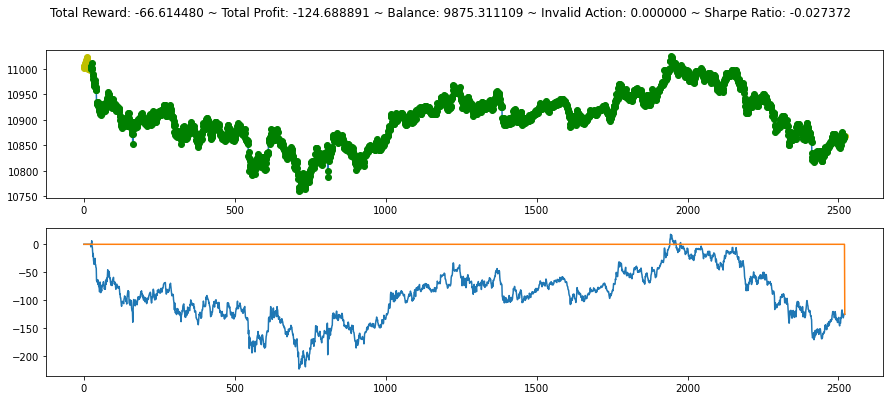

In [7]:
class BuynHoldAgent():

    def __init__(self):
        return

    # return action
    def act(self, obs):
        # 1 = OpenLongPos
        return 1

print("BUY and HOLD agent")
buynhold = BuynHoldAgent()
obs = env.reset()
for i in range(2499):
  action = buynhold.act(obs)
  obs, step_reward, done, info = env.step(action)

env.step(2)
env.render_all(1)

SELL and HOLD agent


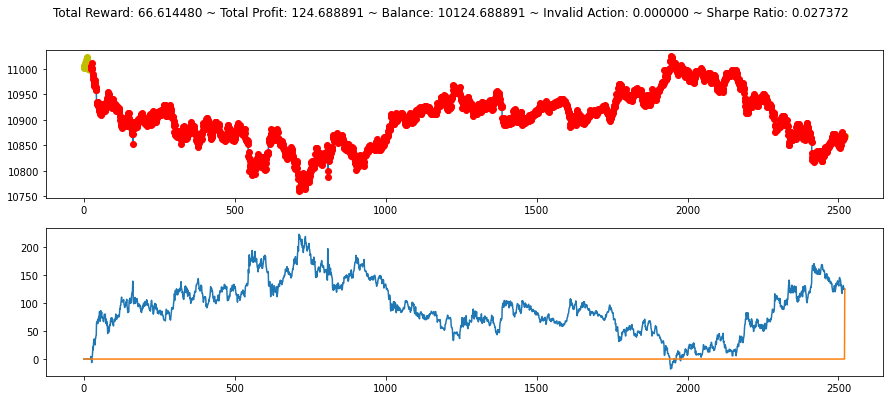

In [8]:
class SellnHoldAgent():

    def __init__(self):
        return

    # return action
    def act(self, obs):
        # 2 = OpenShortPos
        return 2

print("SELL and HOLD agent")
sellnhold = SellnHoldAgent()
obs = env.reset()
for i in range(2499):
  action = sellnhold.act(obs)
  obs, step_reward, done, info = env.step(action)

env.step(1)
env.render_all(1)

MOMENTUM agent


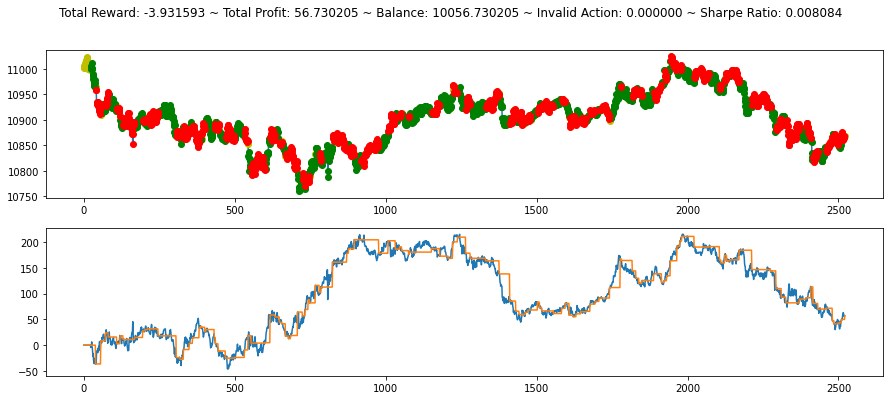

In [9]:
class MomentumAgent():

    def __init__(self):
        return

    def act(self, obs):
        #TODO cambiare nomi colonne
        #obs deve contenere solo le chiusure

        obs = pd.DataFrame(obs,columns=["close"])
        obs['9-day'] = obs['close'].rolling(9).mean()
        obs['20-day'] = obs['close'].rolling(21).mean()

        obs['signal'] = np.where(obs['9-day'] > obs['20-day'], 1, 0)
        obs['signal'] = np.where(obs['9-day'] < obs['20-day'], 2, obs['signal'])

        action = int(obs["signal"].iloc[-1])
        return action

print("MOMENTUM agent")
momentum = MomentumAgent()
obs = env.reset()
for i in range(2499):
  action = momentum.act(obs)
  obs, step_reward, done, info = env.step(action)

if action == 1:
  action = 2
else:
  action = 1
env.step(action)
env.render_all(1)

MOVING AVERAGE CROSSOVER agent


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars


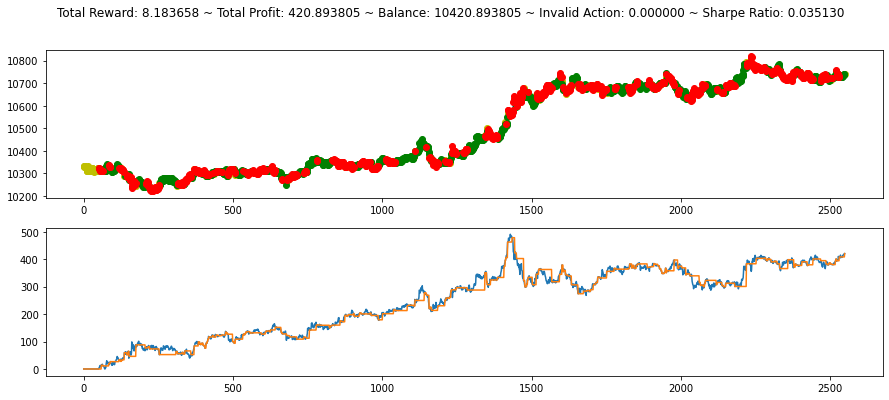

In [10]:
class MovingAverageCrossoverAgent():

    # The second thing of importance is coming to understand the
    # trigger for trading with moving average crossovers.
    # A buy or sell signal is triggered once the smaller moving average crosses above or
    # below the larger moving average, respectively.

    def __init__(self):
        return

    # obs deve contentere ['closes', 'sma']
    # obs dovrebbe essere un numpy
    # TODO controllare che il valore di default di sma in Indicators
    def act(self, obs, sma_down=26, sma_up=27):
        obs = pd.DataFrame(obs, columns=["close", "sma"])
        obs["sma5"] = obs["close"].rolling(window=sma_down).mean()
        obs["sma20"] = obs["close"].rolling(window=sma_up).mean()

        pre_sma5, sma5 = obs.sma5.values[-2], obs.sma5.values[-1]
        pre_sma20, sma20 = obs.sma20.values[-2], obs.sma20.values[-1]

        # BUY SIGNAL = se sma5 incrocia (cioè supera da sotto verso sopra) sma10 compro
        if pre_sma5 < pre_sma20 and sma5 > sma20:
            return 1

        if pre_sma5 > pre_sma20 and sma5 < sma20:
            return 2

        if sma5 < sma20:
            return 2
        if sma5 > sma20:
            return 1

        return 0

print("MOVING AVERAGE CROSSOVER agent")
moving_average_crossover = MovingAverageCrossoverAgent()
env = gym.make(id_str, df=df, frame_bound=(2500, 5000), window_size=50, indicators=['close', 'SMA'], position_in_observation=False)
obs = env.reset()
for i in range(2499):
  action = moving_average_crossover.act(obs)
  obs, step_reward, done, info = env.step(action)

if action == 1:
  action = 2
else:
  action = 1
env.step(action)
env.render_all(1)

In [13]:
class MovingAverageCrossoverAgent():

    # The second thing of importance is coming to understand the
    # trigger for trading with moving average crossovers.
    # A buy or sell signal is triggered once the smaller moving average crosses above or
    # below the larger moving average, respectively.

    def __init__(self):
        return

    # obs deve contentere ['closes', 'sma']
    # obs dovrebbe essere un numpy
    # TODO controllare che il valore di default di sma in Indicators
    def act(self, obs, sma_down=26, sma_up=27):
        obs = pd.DataFrame(obs, columns=["close", "sma"])
        obs["sma5"] = obs["close"].rolling(window=sma_down).mean()
        obs["sma20"] = obs["close"].rolling(window=sma_up).mean()

        pre_sma5, sma5 = obs.sma5.values[-2], obs.sma5.values[-1]
        pre_sma20, sma20 = obs.sma20.values[-2], obs.sma20.values[-1]

        # BUY SIGNAL = se sma5 incrocia (cioè supera da sotto verso sopra) sma10 compro
        if pre_sma5 < pre_sma20 and sma5 > sma20:
            return 1

        if pre_sma5 > pre_sma20 and sma5 < sma20:
            return 2

        if sma5 < sma20:
            return 2
        if sma5 > sma20:
            return 1

        return 0

print("MOVING AVERAGE CROSSOVER agent")
moving_average_crossover = MovingAverageCrossoverAgent()
max_profit = 0.0f
best_l = 1
best_h = 1
for l in range(0, 48):
  print("l =", l)
  print("Max profit = ", max_profit, " --- (l, h) = ", best_l, best_h)
  for h in range(0, 49):
    env = gym.make(id_str, df=df, frame_bound=(2500, 5000), window_size=50, indicators=['close', 'SMA'], position_in_observation=False)
    obs = env.reset()

    for i in range(2499):
      action = moving_average_crossover.act(obs, l, h)
      obs, step_reward, done, info = env.step(action)

    if action == 1:
      action = 2
    else:
      action = 1
    obs, step_reward, done, info = env.step(action)
    if info.get("total_profit") > max_profit:
      max_profit = info.get("total_profit")
      best_l = l
      best_h = h
      print("Update max profit =", max_profit, " --- (l, h) =", best_l, best_h)
print("Max profit = ", max_profit, " --- (l, h) = ", best_l, best_h)

MOVING AVERAGE CROSSOVER agent
l = 0
Max profit =  0.0  --- (l, h) =  1 1
l = 1
Max profit =  0.0  --- (l, h) =  1 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_

l = 2
Max profit =  364.9367961908647  --- (l, h) =  1 24


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_

l = 3
Max profit =  371.7385602758768  --- (l, h) =  2 25


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_

l = 4
Max profit =  422.0243535205027  --- (l, h) =  3 21


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_

l = 5
Max profit =  433.9570460337127  --- (l, h) =  4 20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_

l = 6
Max profit =  465.8636306051685  --- (l, h) =  5 19


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_

l = 7
Max profit =  465.8636306051685  --- (l, h) =  5 19


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_

l = 8
Max profit =  465.8636306051685  --- (l, h) =  5 19


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_

l = 9
Max profit =  474.5403379404888  --- (l, h) =  8 28


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_

l = 10
Max profit =  474.5403379404888  --- (l, h) =  8 28


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_

l = 11
Max profit =  474.5403379404888  --- (l, h) =  8 28


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_

l = 12
Max profit =  474.5403379404888  --- (l, h) =  8 28


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_

l = 13
Max profit =  500.71156964614784  --- (l, h) =  12 24


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_

l = 14
Max profit =  500.71156964614784  --- (l, h) =  12 24


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_

l = 15
Max profit =  500.71156964614784  --- (l, h) =  12 24


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_

l = 16
Max profit =  602.9179444731708  --- (l, h) =  15 23


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars


l = 17
Max profit =  661.2644481778498  --- (l, h) =  16 23


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars


l = 18
Max profit =  661.2644481778498  --- (l, h) =  16 23


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars


l = 19
Max profit =  661.2644481778498  --- (l, h) =  16 23


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars


l = 20
Max profit =  661.2644481778498  --- (l, h) =  16 23


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_

l = 21
Max profit =  661.2644481778498  --- (l, h) =  16 23


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_

l = 22
Max profit =  661.2644481778498  --- (l, h) =  16 23


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars


l = 23
Max profit =  661.2644481778498  --- (l, h) =  16 23


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars


l = 24
Max profit =  661.2644481778498  --- (l, h) =  16 23


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars


l = 25
Max profit =  661.2644481778498  --- (l, h) =  16 23


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars


l = 26
Max profit =  661.2644481778498  --- (l, h) =  16 23


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars


l = 27
Max profit =  661.2644481778498  --- (l, h) =  16 23


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_

l = 28
Max profit =  661.2644481778498  --- (l, h) =  16 23


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_

l = 29
Max profit =  661.2644481778498  --- (l, h) =  16 23


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_

l = 30
Max profit =  661.2644481778498  --- (l, h) =  16 23


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_

l = 31
Max profit =  661.2644481778498  --- (l, h) =  16 23


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars


l = 32
Max profit =  661.2644481778498  --- (l, h) =  16 23


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars


l = 33
Max profit =  661.2644481778498  --- (l, h) =  16 23


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars


l = 34
Max profit =  661.2644481778498  --- (l, h) =  16 23


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars


l = 35
Max profit =  661.2644481778498  --- (l, h) =  16 23


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars


l = 36
Max profit =  661.2644481778498  --- (l, h) =  16 23


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars


l = 37
Max profit =  661.2644481778498  --- (l, h) =  16 23


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars


l = 38
Max profit =  661.2644481778498  --- (l, h) =  16 23


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars


l = 39
Max profit =  661.2644481778498  --- (l, h) =  16 23


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars


l = 40
Max profit =  661.2644481778498  --- (l, h) =  16 23


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_

l = 41
Max profit =  661.2644481778498  --- (l, h) =  16 23


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_

l = 42
Max profit =  661.2644481778498  --- (l, h) =  16 23


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars


l = 43
Max profit =  661.2644481778498  --- (l, h) =  16 23


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars


l = 44
Max profit =  661.2644481778498  --- (l, h) =  16 23


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_

l = 45
Max profit =  661.2644481778498  --- (l, h) =  16 23


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_

l = 46
Max profit =  661.2644481778498  --- (l, h) =  16 23


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_

l = 47
Max profit =  661.2644481778498  --- (l, h) =  16 23


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in double_

Max profit =  661.2644481778498  --- (l, h) =  47 48
